In [26]:
# !pip install kagglehub nibabel
# !pip install PyMaxflow==1.2.15
# !pip uninstall -y numpy
# !pip install numpy==1.26.4

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
%cd /content/drive/MyDrive/Colab_Notebooks/graphcut_unet_segmentation
!ls


/content/drive/MyDrive/Colab_Notebooks/graphcut_unet_segmentation
graphcut.py	   main.py	     __pycache__
inference_unet.py  model_parham.pth  run_in_colab.ipynb


In [29]:
!python main.py

############################### Running main.py ###############################
Path to dataset files: /root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1




2026-02-24 12:07:31.980727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771934852.013709   13366 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771934852.024526   13366 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771934852.049172   13366 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771934852.049211   13366 computation_placer.cc:177] computation placer a

############################### Running main.py ###############################
Path to dataset files: /root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1




/root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1/LiTS(train_test)/test_CT/volume-119.nii
CT shape: (512, 512, 461)
Seg shape: (512, 512, 461)


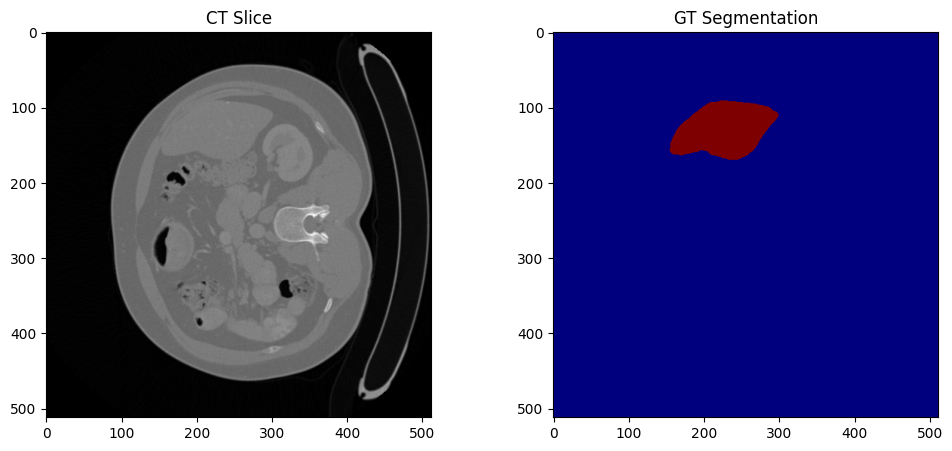

Running inference on: cuda


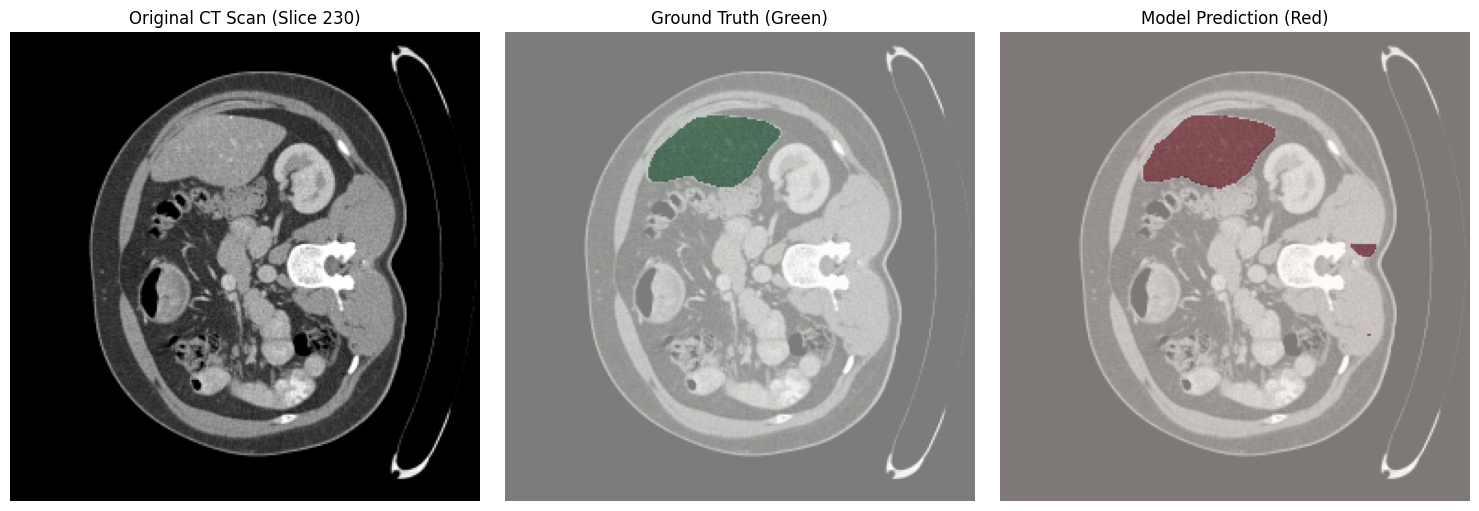

[iter 1/5] Df: 1.371..409.778 | Db: 0.000..29.367
[iter 1/5] maxflow: 8208.172
[iter 2/5] Df: 1.371..409.778 | Db: 0.000..29.367
[iter 2/5] maxflow: 8208.172
[iter 3/5] Df: 1.371..409.778 | Db: 0.000..29.367
[iter 3/5] maxflow: 8208.172
[iter 4/5] Df: 1.371..409.778 | Db: 0.000..29.367
[iter 4/5] maxflow: 8208.172
[iter 5/5] Df: 1.371..409.778 | Db: 0.000..29.367
[iter 5/5] maxflow: 8208.172


In [30]:


print("############################### Running main.py ###############################")

import kagglehub

# Download dataset
path = kagglehub.dataset_download("javariatahir/litstrain-val")

print("Path to dataset files:", path)
print("\n\n\n")

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from graphcut import *
import matplotlib.colors as mcolors
import tensorflow as tf
from keras.layers import TFSMLayer
from keras import Model
from inference_unet import *
import os



volume_path = os.path.join(path, "LiTS(train_test)/test_CT/volume-119.nii")
seg_path = os.path.join(path, "LiTS(train_test)/test_mask/segmentation-119.nii")

print(volume_path)

ct_nii = nib.load(volume_path)
seg_nii = nib.load(seg_path)

ct_volume = ct_nii.get_fdata()
gt_seg = seg_nii.get_fdata()

print("CT shape:", ct_volume.shape)
print("Seg shape:", gt_seg.shape)

import matplotlib.pyplot as plt

slice_idx = ct_volume.shape[2] // 2  # middle slice

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("CT Slice")
plt.imshow(ct_volume[:,:,slice_idx], cmap="gray")

plt.subplot(1,2,2)
plt.title("GT Segmentation")
plt.imshow(gt_seg[:,:,slice_idx], cmap="jet")

plt.show()


img_resized, pred_mask, bg_mask = run_inference(img_path= volume_path, mask_path=seg_path, slice_idx=slice_idx, model_path='model_parham.pth')


seg = graph_cut_iterative(
    img_resized,
    pred_mask,                 # <-- arbitrary shape mask (bool)
    bg_mask,                 # <-- arbitrary shape mask (bool)
    k=30.0,                       # smoothness scale (gamma)
    iterations=5,
    n_components=5,
    fg_prior=0.05,                # tumor small
    hard_seeds=True,
    seed_inf=1e9,
    spatial_weight=0.25,          # how much x,y help (0 disables)
    distance_bias=0.0,            # try 0.0..2.0 if needed
    restrict_to_body=True,        # helps reduce air/background confusion
    body_threshold_hu=-500,       # air is ~ -1000 HU
    keep_component_touching_fg=True,
    verbose=True,
)

